In [11]:
import umap
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
from scipy import cluster, spatial, stats
#from dynamicTreeCut import cutreeHybrid, dynamicTreeCut
import seaborn as sns
import networkx as nx
import phenograph
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_predict
import os
import json
from scipy.stats import wasserstein_distance
from pyemd import emd, emd_with_flow
import os
import dash
import pandas as pd
from dashdataframe import configure_app
from nglui.statebuilder import *
import annotationframeworkclient
from annotationframeworkclient import imagery
import random

#Finished

In [24]:


def distmatfunc(i,j):
    
    DM_E = myobj['Euclidean']
    DM_D = myobj['Depth_Matrix']
    #DM_W = myobj['PSSEuclidean']
    #DM_W = myobj['EarthMovers_%dbins'%numbins]
    DM_W = mymatrix
    
    i = int(i[0]) 
    j = int(j[0]) 
    return facE*DM_E[i,j] + facD*DM_D[i,j] + facW*DM_W[i,j]


def create_random_colors(numcolors):
    allcolors = []
    for i in range(0, numcolors):
        clr = [ round(random.uniform(0, 1),1),round(random.uniform(0, 1),1),round(random.uniform(0, 1),1)]
        allcolors.append(clr)
        
        
    return allcolors
    


In [25]:
#load
numbins = 4
distancetype = 'PSSEuclidean' #'EarthMovers_16bins' #'PSSEuclidean'
myobj = pickle.load( open( "Precalculated_Fixed_Matrices_16bins_normalized.p", "rb" ) )
mymatrix = np.sum(myobj[distancetype][:,:,:numbins],axis=2)
vecM = np.zeros((myobj['neuron_df'].shape[0],1)) 
for i in range(0, myobj['neuron_df'].shape[0]): 
    vecM[i,0] = i 

In [26]:
#PHENOGRAPH CLUSTERING

facE = 1 # soma 
facD = 1
#facD = np.mean(myobj['Euclidean'])/np.mean(myobj['Depth_Matrix']) # y
#facW = np.mean(myobj['Euclidean'])/np.mean(myobj['PSSEuclidean'])# pss
#facW = 50# pss
facW = np.mean(myobj['Euclidean'])/np.mean(mymatrix)

df_drop = myobj['neuron_df']
phenograph_ks = [12]
fac =  0.1
for pk in phenograph_ks:
    communities, graph, Q = phenograph.cluster(vecM, k=pk,primary_metric=distmatfunc)
    ct = communities
    nclusters = np.max(ct)+1
    ncolors=nclusters
    print(Q, nclusters)
    np.unique(communities)
    df_drop.loc[:, 'phenograph_cluster_%d'%pk]=ct
    print(communities)
    
df_drop.loc[:, 'phenograph_cluster']=ct


Finding 12 nearest neighbors using <function distmatfunc at 0x7ff23eb64d90> metric and 'auto' algorithm
Neighbors computed in 67.52486109733582 seconds
Jaccard graph constructed in 1.6480696201324463 seconds
Wrote graph to binary file in 0.0670013427734375 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.840723
After 7 runs, maximum modularity is Q = 0.8427
Louvain completed 27 runs in 3.499069929122925 seconds
PhenoGraph complete in 72.75280666351318 seconds
0.8427 14
[ 3  0 13 ...  2  5  7]


In [27]:
#find mean y for each cluster
allcs = np.unique(ct)
meanvals = []
for c in allcs:
    ctdf = df_drop.loc[df_drop['phenograph_cluster']==c]
    meanvals.append(np.mean(ctdf.y.values))

#order them

sortedinds = sorted(range(len(meanvals)), key=lambda k: meanvals[k])
print(meanvals,sortedinds,allcs)
#rename clusters

origct = ct
newct = np.zeros(len(ct))

for i in range(0,len(allcs)):
    myinds = np.where(ct==sortedinds[i])
    
    newct[myinds] = int(allcs[i])
    
df_drop.loc[:, 'phenograph_cluster']=newct.astype(int)


[459.1463247489131, 583.4966691454152, 423.33561353894464, 158.4345643802103, 343.3919036297087, 582.6490346048605, 494.0391343464625, 172.83447947903895, 303.50170653117044, 383.90692032784506, 412.0440177078907, 284.4997678196586, 149.444292606597, 288.0469671895787] [12, 3, 7, 11, 13, 8, 4, 9, 10, 2, 0, 6, 5, 1] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


<IPython.core.display.Javascript object>


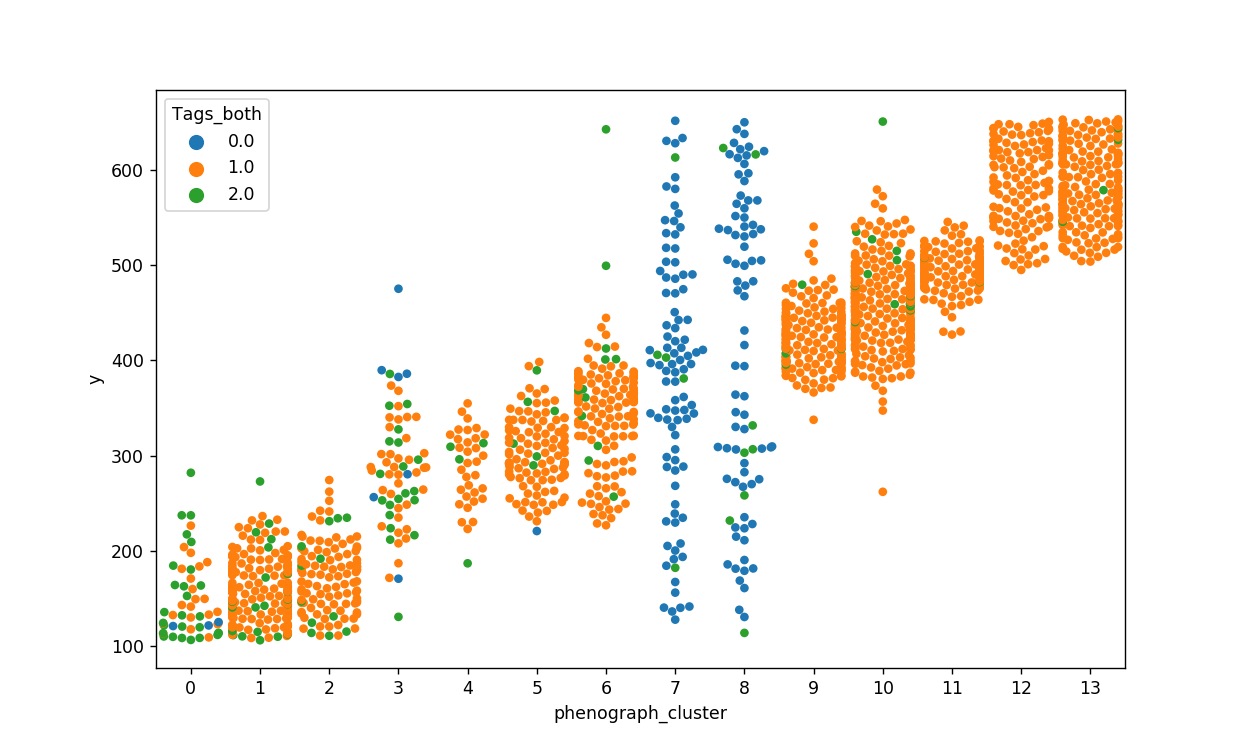

/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 54.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 30.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 26.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 29.2% of the points cannot be placed; you may want to decre

In [28]:


f, ax = plt.subplots(figsize=(10,6))
#sortedclrs = [clrs[s] for s in sortedinds ]
dec = (df_drop.Tags_both=='unsure')*2.0 + (df_drop.Tags_both=='excitatory')*1.0
df_drop['NEWTag'] = dec
snsplot = sns.swarmplot(x='phenograph_cluster', y='y',  data=df_drop, ax=ax, hue = dec)#,palette=sortedclrs)




In [29]:
wronginh = 0
wrongex = 0
for u in np.unique(df_drop['phenograph_cluster']):
    cluster = list(df_drop[df_drop['phenograph_cluster']==u]['NEWTag'].values)
    d = {x:cluster.count(x) for x in cluster}
    1.0 in d.keys()
    if (1.0 in d.keys()) & (0.0 in d.keys()) :
        if d[1.0]  > d[0.0] :
            wronginh += d[0.0]
        if d[0.0]  > d[1.0]:
            wrongex += d[1.0]
        
print("Wrong IN: %d, Wrong EX: %d, Wrong Total: %d"%(wronginh, wrongex, wronginh+wrongex))
print("Weight = ", facW)

Wrong IN: 11, Wrong EX: 0, Wrong Total: 11
Weight =  134.81077270660913


In [39]:
#savedf drop for inhibitory clustering
#somalist = [2528423470294, 3127499820611 ]
#df_drop = df_drop[(df_drop['soma_id'] == somalist[0]) | (df_drop['soma_id'] == somalist[1])]

def get_feature_names(df):
    featurenames = dict()

    featurenames['soma_features'] = ['soma_synapses', 'soma_area', 'soma_area_to_volume',
           'soma_syn_density', 'soma_volume',
           'nucleus_area_largest', 'nucleus_area_to_volume_largest',
           'nucleus_fold_area_largest', 'nucleus_fract_fold_largest',
           'nucleus_volume_largest',
           'nucleus_to_soma_largest','synapse_size_mean_x','synapse_size_median_x']#'nucleus_avg_depth_largest',

    featurenames['depth_features'] = ['y']

    maxsholldist = 16*15000
    pss_features = []
    sa_features = []
    for s in df.keys().values:
        tokens = s.split('_')
        featdist = tokens[-1]
        if ('orig' in s) :
            if (int(featdist) <= int(maxsholldist)):
                pss_features.append(s)
                
        if ('surfacearea_' in s):
            if (int(featdist) <= int(maxsholldist)):
                sa_features.append(s)
    featurenames['pss_features'] = pss_features   
    featurenames['surface_area'] = sa_features
    featurenames['tags'] = ['Tags_LE', 'Tags_FC', 'QClabels']

    return pss_features

testdf = df_drop[df_drop['soma_id']==3943480980175]
pss_features = get_feature_names(testdf)
testdf[pss_features].values

array([[ 1,  2,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  1,  3,  2,  2,  3,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  2,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  2,  5,  0,  8, 11,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  5,  9,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  2,  3,  3,  2,  0,  0,  0,  0,  0,  0,  0, 

In [30]:
from jupyter_dash import JupyterDash

cvpath = 'precomputed://https://storage.googleapis.com/neuroglancer/basil_v0/basil_full/seg-aug'
imageclient = imagery.ImageryClient(segmentation_source=cvpath, graphene_segmentation=False)

FLASKPORT = 8050
plot_columns = df_drop.columns

def make_statebuilder():
    img_source = 'precomputed://https://storage.googleapis.com/neuroglancer/basil_v0/son_of_alignment/v3.04_cracks_only_normalized_rechunked'
    img_layer = ImageLayerConfig(name='img',
                                 source=img_source,
                                 )
    seg_source = imageclient.segmentation_source
    seg_layer = SegmentationLayerConfig(seg_source, selected_ids_column='soma_id')
    return StateBuilder([img_layer, seg_layer])
    
def build_dash_app():
    #app = dash.Dash()
    external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
    app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
    sb = make_statebuilder()
    def render_state(select_indices, render_df):
        render_df = render_df.loc[select_indices]
        return sb.render_state(render_df,
                               return_as='url',
                               url_prefix='https://neuromancer-seung-import.appspot.com/')
    
    configure_app(app, df_drop,
                  link_name='Neuroglancer Link',
                  link_func=render_state,
                 plot_columns = plot_columns)
    return app
app = build_dash_app()
#app.run_server(mode="inline",port=FLASKPORT)
#app.run_server(port=FLASKPORT)
app.run_server(host='0.0.0.0',debug=True, port=8050)

Dash app running on http://0.0.0.0:8050/


In [ ]:
#print(np.max(myobj['Euclidean']),np.std(myobj['Euclidean']),np.mean(myobj['Euclidean']))
#print(np.max(myobj['Depth_Matrix']),np.std(myobj['Depth_Matrix']),np.mean(myobj['Depth_Matrix']))
#print(np.max(myobj['EarthMovers_4bins']),np.std(myobj['EarthMovers_4bins']),np.mean(myobj['EarthMovers_4bins']))

In [ ]:
#(df_drop.Tags_both=='unsure')*2.0 + (df_drop.Tags_both=='excitatory')*1.0